# 02 - Data Preparation & Feature Engineering

## CRISP-DM: Fase 3 - Preparação de Dados

Este notebook implementa a fase de **Data Preparation** da metodologia CRISP-DM para o projeto D4Maia.

### Resumo Executivo

| Tarefa | Descrição |
|--------|-----------|
| **Limpeza de Dados** | Tratamento de valores nulos, filtragem de CPEs com dados insuficientes |
| **Split Temporal** | 70% treino / 30% teste, respeitando ordem cronológica |
| **Feature Engineering** | Criação de features agregadas para clustering e modelos supervisionados |
| **Persistência** | Geração de ficheiros intermédios para notebooks seguintes |

### Features Criadas
- **Estatísticas de consumo**: média, std, min, max, mediana, coeficiente de variação
- **Padrões por hora**: 24 valores (consumo médio por hora do dia)
- **Padrões por dia**: 7 valores (consumo médio por dia da semana)
- **Picos e vales**: hora do pico, valor máximo, hora do vale, valor mínimo
- **Rácios**: fim-de-semana vs dias úteis, manhã vs tarde vs noite

### Ficheiros Gerados
- `d4maia_series_per_cpe.csv` - Séries temporais filtradas
- `d4maia_ts_train_test_index.csv` - Índices de split por CPE
- `d4maia_cpe_features.csv` - Features agregadas por CPE

---

**Referência do Enunciado:**
> "Preparar séries temporais por CPE e feature sets para clustering e modelos supervisionados."

## 1. Importação de Bibliotecas e Carregamento de Dados

Esta seção inicializa o ambiente, importa as bibliotecas necessárias e carrega os dados do dataset D4Maia. Seguimos as melhores práticas de configuração para garantir reprodutibilidade e eficiência no processamento de dados grandes (~6 milhões de registos).

### Estrutura do Notebook:
- **Seção 1:** Importação e carregamento de dados
- **Seção 2:** Preparação de séries temporais (filtragem, features temporais, splits)
- **Seção 3:** Feature engineering para clustering
- **Seção 4:** Análise exploratória das features
- **Seção 5:** Próximos passos
- **Seção 6:** Resumo e conclusões

In [4]:
# MELHORAMENTO: Adicionar constantes configuráveis no início
# =================================================================================
# CONFIGURAÇÕES GERAIS
# =================================================================================
SAMPLE_SIZE = 100000  # Tamanho de sample para visualizações pesadas
RANDOM_STATE = 42     # Seed para reprodutibilidade
VERBOSE = True         # Controle de outputs verbosos

# =================================================================================
# CONFIGURAÇÕES DE QUALIDADE DE DADOS
# =================================================================================
MIN_SEMANAS_DEFAULT = 8           # Mínimo de semanas de dados por CPE
MIN_COMPLETUDE_DEFAULT = 70       # Mínimo de completude (%) por CPE
MAX_MISSING_PCT_DEFAULT = 50      # Máximo de valores nulos aceitáveis (%)
MIN_RECORDS_PER_CPE = 1000        # Mínimo de registos por CPE após filtragem

# =================================================================================
# CONFIGURAÇÕES DE SPLIT TREINO/TESTE
# =================================================================================
TRAIN_RATIO_DEFAULT = 0.70        # Rácio treino/teste para séries temporais
VALIDATION_RATIO = 0.15           # Rácio para validação (se aplicável)
TEST_RATIO = 0.15                 # Rácio para teste (deve somar 1.0 com TRAIN_RATIO)

# =================================================================================
# CONFIGURAÇÕES DE FEATURE ENGINEERING
# =================================================================================
# Outliers
IQR_MULTIPLIER = 1.5              # Multiplicador para detecção de outliers via IQR
ZSCORE_THRESHOLD = 3.0            # Threshold para detecção de outliers via Z-score

# Correlação
CORR_THRESHOLD_HIGH = 0.9         # Threshold para correlação alta (multicolinearidade)
CORR_THRESHOLD_MEDIUM = 0.7       # Threshold para correlação média
CORR_THRESHOLD_LOW = 0.3          # Threshold para correlação baixa

# Variabilidade
ROLLING_WINDOW_DAYS = 7           # Janela para cálculos de média móvel (dias)
MIN_PERIODS_FOR_STATS = 3         # Mínimo de períodos para calcular estatísticas

# =================================================================================
# CONFIGURAÇÕES DE VISUALIZAÇÃO
# =================================================================================
FIG_SIZE_DEFAULT = (10, 6)        # Tamanho padrão de figuras
BINS_DEFAULT = 30                 # Número padrão de bins em histogramas
ALPHA_DEFAULT = 0.7               # Transparência padrão para plots
LINE_WIDTH_DEFAULT = 2.0          # Largura de linha padrão
MARKER_SIZE_DEFAULT = 6.0         # Tamanho de marcador padrão

# Cores para visualizações consistentes
COLOR_PALETTE = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# =================================================================================
# CONFIGURAÇÕES DE PERFORMANCE
# =================================================================================
CHUNK_SIZE = 100000               # Tamanho de chunks para processamento em lote
MEMORY_LIMIT_MB = 1000            # Limite de memória para operações pesadas
TIMEOUT_SECONDS = 300             # Timeout para operações que podem demorar

# =================================================================================
# VALIDAÇÃO DE CONFIGURAÇÕES
# =================================================================================
# Verificar se os rácios de split somam 1.0
total_ratio = TRAIN_RATIO_DEFAULT + TEST_RATIO
if abs(total_ratio - 1.0) > 0.001:
    import warnings
    warnings.warn(f"ATENÇÃO: Rácios de split não somam 1.0 (treino: {TRAIN_RATIO_DEFAULT}, teste: {TEST_RATIO})")

# =================================================================================
# CONFIGURAÇÕES DINÂMICAS (baseadas no dataset)
# =================================================================================
# Estas configurações se adaptam automaticamente ao tamanho e características do dataset

def configurar_parametros_dinamicos(df):
    """
    Configura parâmetros dinâmicos baseados nas características do dataset.
    """
    n_cpes = df['CPE'].nunique()
    n_records = len(df)
    
    # Ajustar sample size baseado no tamanho do dataset
    dynamic_sample_size = min(SAMPLE_SIZE, max(10000, n_records // 10))
    
    # Ajustar bins baseado no número de CPEs
    dynamic_bins = min(BINS_DEFAULT, max(10, n_cpes // 10))
    
    # Ajustar chunk size baseado na memória disponível
    dynamic_chunk_size = min(CHUNK_SIZE, max(10000, n_records // 20))
    
    # Thresholds adaptativos para correlação
    corr_threshold_adaptive = min(CORR_THRESHOLD_HIGH, 0.95 if n_cpes > 50 else 0.85)
    
    return {
        'sample_size': dynamic_sample_size,
        'bins': dynamic_bins,
        'chunk_size': dynamic_chunk_size,
        'corr_threshold_high': corr_threshold_adaptive,
        'n_cpes': n_cpes,
        'n_records': n_records
    }

# Placeholder - será configurado após carregar dados
CONFIG_DINAMICA = {}

print("Sistema de constantes configuráveis inicializado!")
print("Parâmetros dinâmicos serão ajustados após carregamento dos dados.")

# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Cores para visualizações
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("Bibliotecas importadas com sucesso!")

Sistema de constantes configuráveis inicializado!
Parâmetros dinâmicos serão ajustados após carregamento dos dados.
Bibliotecas importadas com sucesso!


In [5]:
# Criar estrutura de pastas para dados intermédios
try:
    os.makedirs('data/intermediate', exist_ok=True)
    print("Pasta 'data/intermediate' criada/verificada.")
except Exception as e:
    print(f"Erro ao criar pasta: {e}")
    raise

Pasta 'data/intermediate' criada/verificada.


In [6]:
# MELHORAMENTO: Verificação de arquivo antes de carregar
DATA_PATH = 'consumo15m_11_2025.csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Arquivo não encontrado: {DATA_PATH}")

print("A carregar os dados...")
try:
    df = pd.read_csv(DATA_PATH, na_values=['NULL', 'null', ''])
    # Converter tstamp para datetime (formato esperado: YYYY-MM-DD HH:MM:SS)
    df['tstamp'] = pd.to_datetime(df['tstamp'], errors='coerce')
    # Verificar se a conversão foi bem-sucedida
    if df['tstamp'].isnull().any():
        print(f"Aviso: {df['tstamp'].isnull().sum()} valores de tstamp não puderam ser convertidos para datetime")
    print(f"Dados carregados com sucesso!")
    print(f"Dimensões: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
    print(f"Período: {df['tstamp'].min()} a {df['tstamp'].max()}")
    print(f"Número de CPEs: {df['CPE'].nunique()}")
except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    raise

# =================================================================================
# CONFIGURAR PARÂMETROS DINÂMICOS APÓS CARREGAMENTO
# =================================================================================
CONFIG_DINAMICA = configurar_parametros_dinamicos(df)

print(f"\n📊 CONFIGURAÇÕES DINÂMICAS AJUSTADAS:")
print(f"  - Sample size dinâmico: {CONFIG_DINAMICA['sample_size']:,} (vs {SAMPLE_SIZE:,} padrão)")
print(f"  - Bins dinâmicos: {CONFIG_DINAMICA['bins']} (vs {BINS_DEFAULT} padrão)")
print(f"  - Chunk size dinâmico: {CONFIG_DINAMICA['chunk_size']:,} (vs {CHUNK_SIZE:,} padrão)")
print(f"  - Threshold correlação adaptado: {CONFIG_DINAMICA['corr_threshold_high']:.2f} (vs {CORR_THRESHOLD_HIGH:.2f} padrão)")

# Usar configurações dinâmicas quando apropriado
SAMPLE_SIZE_ATUAL = CONFIG_DINAMICA['sample_size']
BINS_ATUAL = CONFIG_DINAMICA['bins']
CORR_THRESHOLD_HIGH_ATUAL = CONFIG_DINAMICA['corr_threshold_high']

A carregar os dados...
Dados carregados com sucesso!
Dimensões: 5,940,182 linhas × 6 colunas
Período: 2022-12-31 00:15:00 a 2025-05-01 00:00:00
Número de CPEs: 91

📊 CONFIGURAÇÕES DINÂMICAS AJUSTADAS:
  - Sample size dinâmico: 100,000 (vs 100,000 padrão)
  - Bins dinâmicos: 10 (vs 30 padrão)
  - Chunk size dinâmico: 100,000 (vs 100,000 padrão)
  - Threshold correlação adaptado: 0.90 (vs 0.90 padrão)


In [7]:
# Verificar estrutura dos dados
df.head()

,CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
0,PT0002000089069203YG,2022-12-31 00:15:00,NaN,0.2960,NaN,NaN
1,PT0002000089069203YG,2022-12-31 00:30:00,NaN,0.2920,NaN,NaN
2,PT0002000089069203YG,2022-12-31 00:45:00,NaN,0.2840,NaN,NaN
3,PT0002000089069203YG,2022-12-31 01:00:00,NaN,0.2800,NaN,NaN
4,PT0002000089069203YG,2022-12-31 01:15:00,NaN,0.2720,NaN,NaN


In [8]:
# Definir a variável alvo principal
# Como DadosdeConsumo está 100% nula, usamos PotActiva como variável principal
TARGET_COL = 'PotActiva'
print(f"Variável alvo definida: {TARGET_COL}")
print(f"  Valores válidos: {df[TARGET_COL].notna().sum():,} ({df[TARGET_COL].notna().sum()/len(df)*100:.2f}%)")
print(f"  Valores nulos: {df[TARGET_COL].isna().sum():,} ({df[TARGET_COL].isna().sum()/len(df)*100:.2f}%)")

Variável alvo definida: PotActiva
  Valores válidos: 5,940,182 (100.00%)
  Valores nulos: 0 (0.00%)


---

## 2. Preparação das Séries Temporais por CPE

Esta seção prepara os dados para modelação de séries temporais e clustering. Inclui análise da qualidade dos dados por CPE, filtragem de CPEs com dados insuficientes, criação de features temporais e definição de splits treino/teste temporais.

### Principais Etapas:
- **Análise de Qualidade:** Avaliação da completude e duração dos dados por CPE
- **Filtragem:** Exclusão de CPEs com dados inadequados para modelação
- **Features Temporais:** Criação de colunas auxiliares (hora, dia da semana, etc.)
- **Split Temporal:** Definição de conjuntos treino/teste respeitando a ordem temporal

In [9]:
# Calcular estatísticas por CPE
cpe_stats = df.groupby('CPE').agg(
    n_registos=('tstamp', 'count'),
    inicio=('tstamp', 'min'),
    fim=('tstamp', 'max'),
    pot_activa_mean=(TARGET_COL, 'mean'),
    pot_activa_std=(TARGET_COL, 'std'),
    pot_activa_nulls=(TARGET_COL, lambda x: x.isna().sum())
).reset_index()

# Calcular duração e completude
cpe_stats['dias'] = (cpe_stats['fim'] - cpe_stats['inicio']).dt.days
cpe_stats['semanas'] = cpe_stats['dias'] / 7

# Registos esperados (96 por dia = 4 por hora × 24 horas)
cpe_stats['registos_esperados'] = cpe_stats['dias'] * 96
cpe_stats['completude_pct'] = (cpe_stats['n_registos'] / cpe_stats['registos_esperados'] * 100).round(2)
cpe_stats['nulls_pct'] = (cpe_stats['pot_activa_nulls'] / cpe_stats['n_registos'] * 100).round(2)

print("Estatísticas por CPE:")
print("=" * 100)
cpe_stats.head(10)

Estatísticas por CPE:


,CPE,n_registos,inicio,fim,pot_activa_mean,pot_activa_std,pot_activa_nulls,dias,semanas,registos_esperados,completude_pct,nulls_pct
0,PT0002000032936306KX,38008,2024-03-01 00:15:00,2025-05-01,2.4370,2.7791,0,425,60.7143,40800,93.1600,0.0000
1,PT0002000032942455NH,32058,2024-06-01 00:15:00,2025-05-01,0.0909,0.1312,0,333,47.5714,31968,100.2800,0.0000
2,PT0002000032959511HP,43666,2024-02-01 00:15:00,2025-05-01,0.0000,0.0000,0,454,64.8571,43584,100.1900,0.0000
3,PT0002000032966446CC,35081,2024-05-01 00:15:00,2025-05-01,0.0998,0.1051,0,364,52.0000,34944,100.3900,0.0000
4,PT0002000032968749YT,43668,2024-02-01 00:00:00,2025-05-01,3.6398,4.0012,0,455,65.0000,43680,99.9700,0.0000
5,PT0002000032969229AC,40883,2024-02-01 00:00:00,2025-05-01,2.0688,2.9119,0,455,65.0000,43680,93.6000,0.0000
6,PT0002000032976997LZ,55379,2023-09-01 00:15:00,2025-05-01,3.0394,3.1738,0,607,86.7143,58272,95.0400,0.0000
7,PT0002000032990792KD,37911,2024-04-01 00:15:00,2025-05-01,2.3355,3.3711,0,394,56.2857,37824,100.2300,0.0000
8,PT0002000032993611ME,55378,2023-09-01 00:15:00,2025-05-01,0.8495,1.0068,0,607,86.7143,58272,95.0300,0.0000
9,PT0002000033016394FN,55386,2023-09-01 00:15:00,2025-05-01,1.1993,1.1874,0,607,86.7143,58272,95.0500,0.0000


In [10]:
# Resumo das estatísticas
print("=" * 80)
print("RESUMO DA QUALIDADE DOS DADOS POR CPE")
print("=" * 80)
print(f"\nNúmero total de CPEs: {len(cpe_stats)}")
print(f"\nRegistos por CPE:")
print(f"  Mínimo:  {cpe_stats['n_registos'].min():,}")
print(f"  Máximo:  {cpe_stats['n_registos'].max():,}")
print(f"  Média:   {cpe_stats['n_registos'].mean():,.0f}")
print(f"  Mediana: {cpe_stats['n_registos'].median():,.0f}")
print(f"\nDuração dos dados (semanas):")
print(f"  Mínimo:  {cpe_stats['semanas'].min():.1f}")
print(f"  Máximo:  {cpe_stats['semanas'].max():.1f}")
print(f"  Média:   {cpe_stats['semanas'].mean():.1f}")
print(f"\nCompletude dos dados (%):")
print(f"  Mínimo:  {cpe_stats['completude_pct'].min():.1f}%")
print(f"  Máximo:  {cpe_stats['completude_pct'].max():.1f}%")
print(f"  Média:   {cpe_stats['completude_pct'].mean():.1f}%")

RESUMO DA QUALIDADE DOS DADOS POR CPE

Número total de CPEs: 91

Registos por CPE:
  Mínimo:  14,490
  Máximo:  81,776
  Média:   65,277
  Mediana: 78,699

Duração dos dados (semanas):
  Mínimo:  21.4
  Máximo:  121.6
  Média:   101.1

Completude dos dados (%):
  Mínimo:  60.7%
  Máximo:  100.6%
  Média:   96.6%


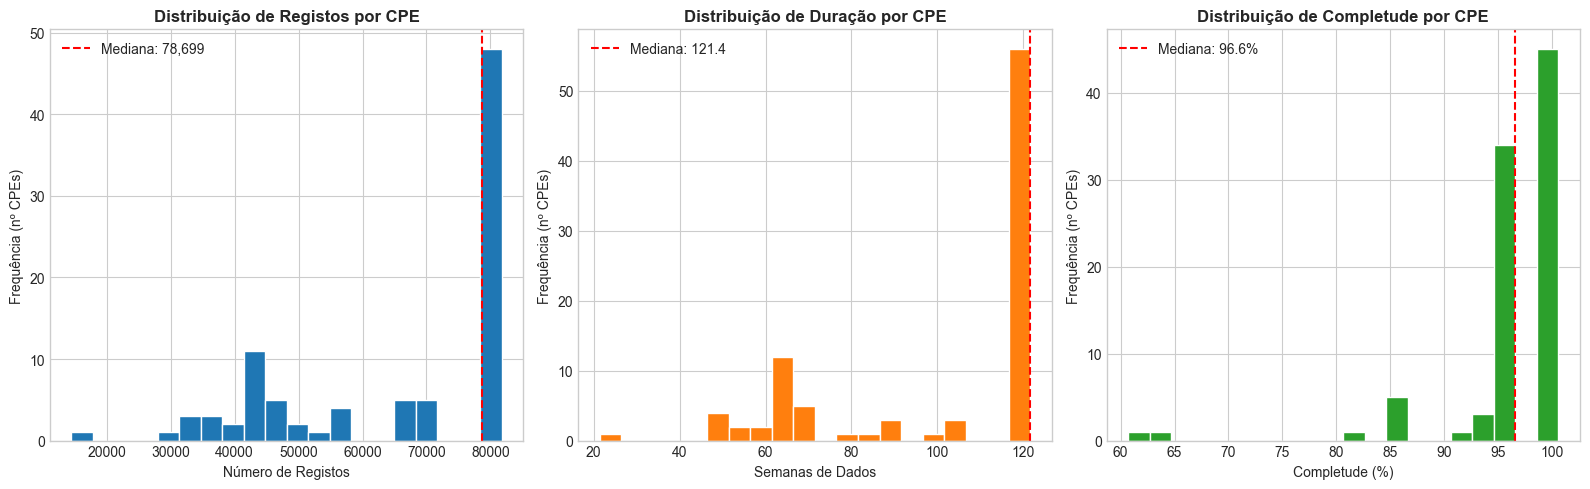

In [11]:
# Visualização da distribuição de registos e completude
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histograma de registos
ax1 = axes[0]
ax1.hist(cpe_stats['n_registos'], bins=20, color=COLORS[0], edgecolor='white')
ax1.set_xlabel('Número de Registos')
ax1.set_ylabel('Frequência (nº CPEs)')
ax1.set_title('Distribuição de Registos por CPE', fontweight='bold')
ax1.axvline(cpe_stats['n_registos'].median(), color='red', linestyle='--', label=f'Mediana: {cpe_stats["n_registos"].median():,.0f}')
ax1.legend()

# Histograma de semanas
ax2 = axes[1]
ax2.hist(cpe_stats['semanas'], bins=20, color=COLORS[1], edgecolor='white')
ax2.set_xlabel('Semanas de Dados')
ax2.set_ylabel('Frequência (nº CPEs)')
ax2.set_title('Distribuição de Duração por CPE', fontweight='bold')
ax2.axvline(cpe_stats['semanas'].median(), color='red', linestyle='--', label=f'Mediana: {cpe_stats["semanas"].median():.1f}')
ax2.legend()

# Histograma de completude
ax3 = axes[2]
ax3.hist(cpe_stats['completude_pct'], bins=20, color=COLORS[2], edgecolor='white')
ax3.set_xlabel('Completude (%)')
ax3.set_ylabel('Frequência (nº CPEs)')
ax3.set_title('Distribuição de Completude por CPE', fontweight='bold')
ax3.axvline(cpe_stats['completude_pct'].median(), color='red', linestyle='--', label=f'Mediana: {cpe_stats["completude_pct"].median():.1f}%')
ax3.legend()

plt.tight_layout()
plt.show()

### 2.2 Filtrar CPEs com Dados Insuficientes

Para garantir qualidade nas análises de séries temporais e clustering, vamos definir critérios mínimos:
- **Mínimo de semanas**: pelo menos {MIN_SEMANAS_DEFAULT} semanas de dados (para ter treino e teste suficientes)
- **Mínimo de completude**: pelo menos {MIN_COMPLETUDE_DEFAULT}% dos registos esperados

Estes critérios asseguram que temos dados suficientes para modelação estatística robusta e evitam overfitting em CPEs com poucos dados.

In [12]:
# Definir critérios de filtragem
MIN_SEMANAS = MIN_SEMANAS_DEFAULT
MIN_COMPLETUDE = MIN_COMPLETUDE_DEFAULT

print(f"Critérios de filtragem:")
print(f"  - Mínimo de semanas: {MIN_SEMANAS}")
print(f"  - Mínimo de completude: {MIN_COMPLETUDE}%")

Critérios de filtragem:
  - Mínimo de semanas: 8
  - Mínimo de completude: 70%


In [13]:
# Aplicar filtros
cpe_stats['valido'] = (
    (cpe_stats['semanas'] >= MIN_SEMANAS) & 
    (cpe_stats['completude_pct'] >= MIN_COMPLETUDE)
)

cpes_validos = cpe_stats[cpe_stats['valido']]['CPE'].tolist()
cpes_excluidos = cpe_stats[~cpe_stats['valido']]['CPE'].tolist()

print(f"\nResultado da filtragem:")
print(f"  CPEs válidos: {len(cpes_validos)} ({len(cpes_validos)/len(cpe_stats)*100:.1f}%)")
print(f"  CPEs excluídos: {len(cpes_excluidos)} ({len(cpes_excluidos)/len(cpe_stats)*100:.1f}%)")


Resultado da filtragem:
  CPEs válidos: 89 (97.8%)
  CPEs excluídos: 2 (2.2%)


In [14]:
# Mostrar CPEs excluídos (se houver)
if len(cpes_excluidos) > 0:
    print("\nCPEs excluídos:")
    print("=" * 100)
    excluidos_df = cpe_stats[~cpe_stats['valido']][['CPE', 'n_registos', 'semanas', 'completude_pct']]
    print(excluidos_df.to_string(index=False))
else:
    print("\nNenhum CPE foi excluído. Todos cumprem os critérios mínimos.")


CPEs excluídos:
                 CPE  n_registos  semanas  completude_pct
PT0002000079901964CJ       49524 121.4286         60.6900
PT0002000089069203YG       52402 121.5714         64.1400


In [15]:
# Filtrar o DataFrame principal para conter apenas CPEs válidos
df_filtered = df[df['CPE'].isin(cpes_validos)].copy()

print(f"\nDataset filtrado:")
print(f"  Registos originais: {len(df):,}")
print(f"  Registos após filtro: {len(df_filtered):,}")
print(f"  Registos removidos: {len(df) - len(df_filtered):,} ({(len(df) - len(df_filtered))/len(df)*100:.2f}%)")


Dataset filtrado:
  Registos originais: 5,940,182
  Registos após filtro: 5,838,256
  Registos removidos: 101,926 (1.72%)


### 2.3 Criar Colunas Temporais Auxiliares

In [16]:
# Criar colunas temporais
df_filtered['hora'] = df_filtered['tstamp'].dt.hour
df_filtered['minuto'] = df_filtered['tstamp'].dt.minute
df_filtered['dia_semana'] = df_filtered['tstamp'].dt.dayofweek  # 0=Segunda, 6=Domingo
df_filtered['dia_mes'] = df_filtered['tstamp'].dt.day
df_filtered['mes'] = df_filtered['tstamp'].dt.month
df_filtered['ano'] = df_filtered['tstamp'].dt.year
df_filtered['is_weekend'] = df_filtered['dia_semana'].isin([5, 6]).astype(int)
df_filtered['periodo_dia'] = pd.cut(
    df_filtered['hora'], 
    bins=[-1, 6, 12, 18, 24], 
    labels=['Noite', 'Manhã', 'Tarde', 'Noite2']
)
df_filtered['periodo_dia'] = df_filtered['periodo_dia'].replace('Noite2', 'Noite')

print("Colunas temporais criadas:")
print("  - hora, minuto")
print("  - dia_semana (0-6), dia_mes, mes, ano")
print("  - is_weekend (0/1)")
print("  - periodo_dia (Noite/Manhã/Tarde)")

df_filtered.head()

Colunas temporais criadas:
  - hora, minuto
  - dia_semana (0-6), dia_mes, mes, ano
  - is_weekend (0/1)
  - periodo_dia (Noite/Manhã/Tarde)


,CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac,hora,minuto,dia_semana,dia_mes,mes,ano,is_weekend,periodo_dia
8732,PT0002000068856906VS,2022-12-31 00:15:00,NaN,4.0000,0.0000,1.0000,0,15,5,31,12,2022,1,Noite
8733,PT0002000068856906VS,2022-12-31 00:30:00,NaN,4.0000,0.0000,0.0000,0,30,5,31,12,2022,1,Noite
8734,PT0002000068856906VS,2022-12-31 00:45:00,NaN,5.0000,1.0000,0.0000,0,45,5,31,12,2022,1,Noite
8735,PT0002000068856906VS,2022-12-31 01:00:00,NaN,4.0000,1.0000,0.0000,1,0,5,31,12,2022,1,Noite
8736,PT0002000068856906VS,2022-12-31 01:15:00,NaN,5.0000,1.0000,0.0000,1,15,5,31,12,2022,1,Noite


### 2.4 Definir Split Treino/Teste ({TRAIN_RATIO_DEFAULT*100:.0f}%/{(1-TRAIN_RATIO_DEFAULT)*100:.0f}%)

Para cada CPE, vamos definir o ponto de corte temporal que separa {TRAIN_RATIO_DEFAULT*100:.0f}% dos dados para treino e {((1-TRAIN_RATIO_DEFAULT)*100):.0f}% para teste. Este split respeita a ordem temporal, crucial para séries temporais, evitando data leakage.

In [17]:
# Calcular split temporal para cada CPE
TRAIN_RATIO = TRAIN_RATIO_DEFAULT

split_info = []

for cpe in cpes_validos:
    df_cpe = df_filtered[df_filtered['CPE'] == cpe].sort_values('tstamp')
    n_total = len(df_cpe)
    n_train = int(n_total * TRAIN_RATIO)
    
    # O timestamp de split é o último timestamp do conjunto de treino
    split_timestamp = df_cpe.iloc[n_train - 1]['tstamp']
    
    split_info.append({
        'CPE': cpe,
        'n_total': n_total,
        'n_train': n_train,
        'n_test': n_total - n_train,
        'split_timestamp': split_timestamp,
        'inicio': df_cpe['tstamp'].min(),
        'fim': df_cpe['tstamp'].max()
    })

split_df = pd.DataFrame(split_info)
print(f"Split treino/teste definido para {len(split_df)} CPEs")
print(f"\nRácio: {TRAIN_RATIO*100:.0f}% treino / {(1-TRAIN_RATIO)*100:.0f}% teste")
split_df.head(10)

Split treino/teste definido para 89 CPEs

Rácio: 70% treino / 30% teste


,CPE,n_total,n_train,n_test,split_timestamp,inicio,fim
0,PT0002000032936306KX,38008,26605,11403,2025-01-02 04:00:00,2024-03-01 00:15:00,2025-05-01
1,PT0002000032942455NH,32058,22440,9618,2025-01-20 18:15:00,2024-06-01 00:15:00,2025-05-01
2,PT0002000032959511HP,43666,30566,13100,2024-12-15 11:00:00,2024-02-01 00:15:00,2025-05-01
3,PT0002000032966446CC,35081,24556,10525,2025-01-11 07:30:00,2024-05-01 00:15:00,2025-05-01
4,PT0002000032968749YT,43668,30567,13101,2024-12-15 11:15:00,2024-02-01 00:00:00,2025-05-01
5,PT0002000032969229AC,40883,28618,12265,2024-12-24 04:15:00,2024-02-01 00:00:00,2025-05-01
6,PT0002000032976997LZ,55379,38765,16614,2024-11-08 20:45:00,2023-09-01 00:15:00,2025-05-01
7,PT0002000032990792KD,37911,26537,11374,2025-01-02 10:45:00,2024-04-01 00:15:00,2025-05-01
8,PT0002000032993611ME,55378,38764,16614,2024-11-08 20:45:00,2023-09-01 00:15:00,2025-05-01
9,PT0002000033016394FN,55386,38770,16616,2024-11-08 21:15:00,2023-09-01 00:15:00,2025-05-01


In [18]:
# Verificar a distribuição dos splits
print("\nEstatísticas do split:")
print(f"  Registos de treino por CPE:")
print(f"    Mínimo: {split_df['n_train'].min():,}")
print(f"    Máximo: {split_df['n_train'].max():,}")
print(f"    Média:  {split_df['n_train'].mean():,.0f}")
print(f"  Registos de teste por CPE:")
print(f"    Mínimo: {split_df['n_test'].min():,}")
print(f"    Máximo: {split_df['n_test'].max():,}")
print(f"    Média:  {split_df['n_test'].mean():,.0f}")


Estatísticas do split:
  Registos de treino por CPE:
    Mínimo: 10,143
    Máximo: 57,243
    Média:  45,918
  Registos de teste por CPE:
    Mínimo: 4,347
    Máximo: 24,533
    Média:  19,680


In [19]:
# Guardar índice de splits
split_df.to_csv('data/intermediate/d4maia_ts_train_test_index.csv', index=False)
print("\n✓ Ficheiro guardado: data/intermediate/d4maia_ts_train_test_index.csv")


✓ Ficheiro guardado: data/intermediate/d4maia_ts_train_test_index.csv


### 2.5 Guardar Séries Temporais Preparadas

In [20]:
# Selecionar colunas relevantes para séries temporais
cols_series = ['CPE', 'tstamp', TARGET_COL, 'PotReactIndut', 'PotReactCapac', 
               'hora', 'dia_semana', 'is_weekend', 'periodo_dia']

# Verificar quais colunas existem
cols_series = [col for col in cols_series if col in df_filtered.columns]

df_series = df_filtered[cols_series].copy()
print(f"Colunas selecionadas para séries temporais: {cols_series}")
print(f"Dimensões: {df_series.shape}")

Colunas selecionadas para séries temporais: ['CPE', 'tstamp', 'PotActiva', 'PotReactIndut', 'PotReactCapac', 'hora', 'dia_semana', 'is_weekend', 'periodo_dia']
Dimensões: (5838256, 9)


In [21]:
# Guardar séries temporais em CSV (não requer pyarrow)
df_series.to_csv('data/intermediate/d4maia_series_per_cpe.csv', index=False)
print("\n✓ Ficheiro guardado: data/intermediate/d4maia_series_per_cpe.csv")


✓ Ficheiro guardado: data/intermediate/d4maia_series_per_cpe.csv


---

## 3. Feature Engineering para Clustering

Vamos criar um conjunto de features agregadas por CPE que caracterizem o perfil de consumo de cada instalação. Estas features serão usadas para identificar padrões de consumo através de algoritmos de clustering não supervisionado.

### Categorias de Features:
- **Estatísticas Gerais:** Média, desvio padrão, quartis do consumo
- **Padrões Temporais:** Consumo por hora, dia da semana, período do dia
- **Características de Pico:** Horas de pico/vale, rácios dia/noite
- **Variabilidade:** Intra e inter-diária

O objetivo é criar uma representação rica de cada CPE que capture diferentes aspectos do seu comportamento de consumo.

In [22]:
# Features básicas de consumo
# Calculamos estatísticas descritivas por CPE para caracterizar o consumo geral
features_basicas = df_filtered.groupby('CPE').agg(
    # Estatísticas gerais
    consumo_mean=(TARGET_COL, 'mean'),
    consumo_std=(TARGET_COL, 'std'),
    consumo_min=(TARGET_COL, 'min'),
    consumo_max=(TARGET_COL, 'max'),
    consumo_median=(TARGET_COL, 'median'),
    consumo_q25=(TARGET_COL, lambda x: x.quantile(0.25)),
    consumo_q75=(TARGET_COL, lambda x: x.quantile(0.75)),
    n_registos=('tstamp', 'count')
).reset_index()

# Coeficiente de variação (CV = std/mean) - mede variabilidade relativa
features_basicas['consumo_cv'] = features_basicas['consumo_std'] / features_basicas['consumo_mean']

# Amplitude interquartil normalizada - mede dispersão relativa
features_basicas['consumo_iqr_norm'] = (features_basicas['consumo_q75'] - features_basicas['consumo_q25']) / features_basicas['consumo_mean']

print(f"Features básicas criadas: {features_basicas.shape[1] - 1} features para {features_basicas.shape[0]} CPEs")
features_basicas.head()

Features básicas criadas: 10 features para 89 CPEs


,CPE,consumo_mean,consumo_std,consumo_min,consumo_max,consumo_median,consumo_q25,consumo_q75,n_registos,consumo_cv,consumo_iqr_norm
0,PT0002000032936306KX,2.4370,2.7791,0.0000,30.7560,0.0000,0.0000,5.3560,38008,1.1404,2.1978
1,PT0002000032942455NH,0.0909,0.1312,0.0000,2.8600,0.0600,0.0200,0.1080,32058,1.4430,0.9682
2,PT0002000032959511HP,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,43666,NaN,NaN
3,PT0002000032966446CC,0.0998,0.1051,0.0000,2.2440,0.0840,0.0280,0.1440,35081,1.0539,1.1628
4,PT0002000032968749YT,3.6398,4.0012,0.0000,31.4960,2.0360,1.1600,4.3650,43668,1.0993,0.8806


### 3.2 Features por Período do Dia

In [23]:
# Consumo médio por período do dia
consumo_periodo = df_filtered.groupby(['CPE', 'periodo_dia'])[TARGET_COL].mean().unstack(fill_value=0)
consumo_periodo.columns = [f'consumo_{col.lower()}' for col in consumo_periodo.columns]
consumo_periodo = consumo_periodo.reset_index()

print(f"Features por período do dia: {consumo_periodo.shape[1] - 1} features")
consumo_periodo.head()

Features por período do dia: 3 features


,CPE,consumo_noite,consumo_manhã,consumo_tarde
0,PT0002000032936306KX,4.6390,0.2707,0.2009
1,PT0002000032942455NH,0.0924,0.0825,0.0963
2,PT0002000032959511HP,0.0000,0.0000,0.0000
3,PT0002000032966446CC,0.1035,0.0846,0.1074
4,PT0002000032968749YT,2.0120,6.4365,4.0968


In [24]:
# Consumo médio por hora do dia (24 features)
consumo_hora = df_filtered.groupby(['CPE', 'hora'])[TARGET_COL].mean().unstack(fill_value=0)
consumo_hora.columns = [f'consumo_h{h:02d}' for h in consumo_hora.columns]
consumo_hora = consumo_hora.reset_index()

print(f"Features por hora do dia: {consumo_hora.shape[1] - 1} features")
consumo_hora.head()

Features por hora do dia: 24 features


,CPE,consumo_h00,consumo_h01,consumo_h02,consumo_h03,consumo_h04,consumo_h05,consumo_h06,consumo_h07,consumo_h08,consumo_h09,consumo_h10,consumo_h11,consumo_h12,consumo_h13,consumo_h14,consumo_h15,consumo_h16,consumo_h17,consumo_h18,consumo_h19,consumo_h20,consumo_h21,consumo_h22,consumo_h23
0,PT0002000032936306KX,5.1665,5.1793,5.1853,5.1870,5.1811,5.1666,4.2632,1.4933,0.1273,0.0000,0.0039,0.0000,0.0000,0.0000,0.0042,0.0011,0.0152,0.2115,0.9737,2.0375,3.0789,4.8444,5.1916,5.1896
1,PT0002000032942455NH,0.0946,0.0781,0.0687,0.0650,0.0626,0.0636,0.0687,0.0835,0.0900,0.0689,0.0692,0.0889,0.0945,0.1010,0.0990,0.0957,0.0952,0.1022,0.0850,0.0872,0.0886,0.1482,0.1558,0.1275
2,PT0002000032959511HP,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,PT0002000032966446CC,0.0986,0.0932,0.0900,0.0883,0.0833,0.0809,0.0821,0.0791,0.0789,0.0841,0.0921,0.0871,0.0863,0.0916,0.0956,0.1070,0.1103,0.1111,0.1287,0.1246,0.1174,0.1231,0.1411,0.1196
4,PT0002000032968749YT,2.1269,2.1892,2.1657,2.2047,2.2639,2.2776,2.2360,2.6115,6.9419,7.3681,6.9998,7.0439,7.6538,6.7704,4.3295,3.8209,3.4999,3.3677,2.7924,1.8181,1.5781,1.6081,1.6096,2.0666


### 3.3 Features por Dia da Semana

In [25]:
# Consumo médio por dia da semana
dias_nome = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
consumo_dia_semana = df_filtered.groupby(['CPE', 'dia_semana'])[TARGET_COL].mean().unstack(fill_value=0)
consumo_dia_semana.columns = [f'consumo_{dias_nome[d]}' for d in consumo_dia_semana.columns]
consumo_dia_semana = consumo_dia_semana.reset_index()

print(f"Features por dia da semana: {consumo_dia_semana.shape[1] - 1} features")
consumo_dia_semana.head()

Features por dia da semana: 7 features


,CPE,consumo_seg,consumo_ter,consumo_qua,consumo_qui,consumo_sex,consumo_sab,consumo_dom
0,PT0002000032936306KX,2.3331,2.4683,2.4174,2.6106,2.4072,2.4186,2.4056
1,PT0002000032942455NH,0.1681,0.1112,0.0621,0.0935,0.0706,0.0664,0.0638
2,PT0002000032959511HP,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,PT0002000032966446CC,0.1010,0.0999,0.1200,0.1017,0.0936,0.0900,0.0919
4,PT0002000032968749YT,4.2518,4.4934,4.3304,4.4677,4.3097,1.8069,1.8160


In [26]:
# Rácio fim de semana vs dias úteis
consumo_weekend = df_filtered.groupby(['CPE', 'is_weekend'])[TARGET_COL].mean().unstack(fill_value=0)
consumo_weekend.columns = ['consumo_dias_uteis', 'consumo_fim_semana']
consumo_weekend = consumo_weekend.reset_index()
consumo_weekend['racio_weekend_util'] = consumo_weekend['consumo_fim_semana'] / consumo_weekend['consumo_dias_uteis']

print("\nRácio fim de semana / dias úteis:")
consumo_weekend.head()


Rácio fim de semana / dias úteis:


,CPE,consumo_dias_uteis,consumo_fim_semana,racio_weekend_util
0,PT0002000032936306KX,2.4469,2.4121,0.9858
1,PT0002000032942455NH,0.1013,0.0651,0.6428
2,PT0002000032959511HP,0.0000,0.0000,NaN
3,PT0002000032966446CC,0.1033,0.0909,0.8804
4,PT0002000032968749YT,4.3706,1.8115,0.4145


### 3.4 Features de Padrão de Pico

In [27]:
# MELHORADO: Calcular features de pico para cada CPE com features OBRIGATÓRIAS do enunciado
def calcular_features_pico(grupo):
    """
    Calcula features de pico e padrões temporais para cada CPE.
    Inclui as features OBRIGATÓRIAS do enunciado:
    - avg_afternoon_peak_value
    - avg_daily_peak_time
    - avg_time_below_50%_consumption
    """
    # Consumo por hora
    consumo_por_hora = grupo.groupby('hora')[TARGET_COL].mean()
    
    # FEATURE OBRIGATÓRIA 1: avg_daily_peak_time (hora média do pico diário)
    # Calculamos a hora do pico para cada dia e depois fazemos a média
    grupo_copy = grupo.copy()
    grupo_copy['data'] = grupo_copy['tstamp'].dt.date
    
    # Para cada dia, encontrar a hora do pico
    picos_diarios = []
    for data, grupo_dia in grupo_copy.groupby('data'):
        consumo_por_hora_dia = grupo_dia.groupby('hora')[TARGET_COL].mean()
        if len(consumo_por_hora_dia) > 0:
            hora_pico_dia = consumo_por_hora_dia.idxmax()
            picos_diarios.append(hora_pico_dia)
    
    avg_daily_peak_time = np.mean(picos_diarios) if len(picos_diarios) > 0 else consumo_por_hora.idxmax()
    
    # Hora do pico (média geral)
    hora_pico = consumo_por_hora.idxmax()
    valor_pico = consumo_por_hora.max()
    
    # FEATURE OBRIGATÓRIA 2: avg_afternoon_peak_value (picos entre 12h e 18h)
    # Calculamos o valor médio dos picos da tarde para cada dia
    picos_tarde_diarios = []
    for data, grupo_dia in grupo_copy.groupby('data'):
        mask_tarde = (grupo_dia['hora'] >= 12) & (grupo_dia['hora'] < 18)
        if mask_tarde.sum() > 0:
            pico_tarde_dia = grupo_dia.loc[mask_tarde, TARGET_COL].max()
            picos_tarde_diarios.append(pico_tarde_dia)
    
    avg_afternoon_peak_value = np.mean(picos_tarde_diarios) if len(picos_tarde_diarios) > 0 else \
                               consumo_por_hora[(consumo_por_hora.index >= 12) & (consumo_por_hora.index < 18)].mean()
    
    # Consumo médio da tarde (para compatibilidade)
    consumo_pico_tarde = consumo_por_hora[(consumo_por_hora.index >= 12) & (consumo_por_hora.index < 18)].mean()
    
    # FEATURE OBRIGATÓRIA 3: avg_time_below_50%_consumption
    # Proporção de amostras abaixo de 50% do pico típico
    # O pico típico é a mediana dos valores máximos diários
    picos_tipicos = []
    for data, grupo_dia in grupo_copy.groupby('data'):
        pico_dia = grupo_dia[TARGET_COL].max()
        picos_tipicos.append(pico_dia)
    
    pico_tipico = np.median(picos_tipicos) if len(picos_tipicos) > 0 else valor_pico
    threshold_50pct = pico_tipico * 0.5
    amostras_abaixo_50pct = (grupo[TARGET_COL] < threshold_50pct).sum()
    total_amostras = len(grupo)
    avg_time_below_50pct_consumption = amostras_abaixo_50pct / total_amostras if total_amostras > 0 else 0
    
    # Hora do vale (mínimo)
    hora_vale = consumo_por_hora.idxmin()
    valor_vale = consumo_por_hora.min()
    
    # Rácio pico/vale
    racio_pico_vale = valor_pico / valor_vale if valor_vale > 0 else np.nan
    
    # Consumo em horário noturno (0h-6h)
    consumo_noturno = consumo_por_hora[(consumo_por_hora.index >= 0) & (consumo_por_hora.index < 6)].mean()
    
    # Rácio dia/noite
    consumo_diurno = consumo_por_hora[(consumo_por_hora.index >= 6) & (consumo_por_hora.index < 22)].mean()
    racio_dia_noite = consumo_diurno / consumo_noturno if consumo_noturno > 0 else np.nan
    
    return pd.Series({
        # Features obrigatórias do enunciado (nomes exatos)
        'avg_afternoon_peak_value': avg_afternoon_peak_value,
        'avg_daily_peak_time': avg_daily_peak_time,
        'avg_time_below_50%_consumption': avg_time_below_50pct_consumption,
        # Features adicionais (compatibilidade)
        'hora_pico': hora_pico,
        'valor_pico': valor_pico,
        'hora_vale': hora_vale,
        'valor_vale': valor_vale,
        'racio_pico_vale': racio_pico_vale,
        'consumo_pico_tarde': consumo_pico_tarde,
        'consumo_noturno': consumo_noturno,
        'racio_dia_noite': racio_dia_noite
    })

features_pico = df_filtered.groupby('CPE').apply(calcular_features_pico).reset_index()
print(f"Features de pico: {features_pico.shape[1] - 1} features")
features_pico.head()

Features de pico: 11 features


,CPE,avg_afternoon_peak_value,avg_daily_peak_time,avg_time_below_50%_consumption,hora_pico,valor_pico,hora_vale,valor_vale,racio_pico_vale,consumo_pico_tarde,consumo_noturno,racio_dia_noite
0,PT0002000032936306KX,0.5019,7.6382,0.5532,22.0000,5.1916,9.0000,0.0000,NaN,0.0387,5.1776,0.2059
1,PT0002000032942455NH,0.1205,17.2985,0.5905,22.0000,0.1558,4.0000,0.0626,2.4892,0.0979,0.0721,1.2705
2,PT0002000032959511HP,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,NaN
3,PT0002000032966446CC,0.1982,14.1667,0.6354,22.0000,0.1411,8.0000,0.0789,1.7880,0.1003,0.0890,1.1226
4,PT0002000032968749YT,9.2705,10.4167,0.7986,12.0000,7.6538,20.0000,1.5781,4.8500,4.9070,2.2047,1.9969


### 3.5 Features de Variabilidade

In [28]:
# Calcular variabilidade intra-dia
def calcular_variabilidade(grupo):
    # Agrupar por dia e calcular estatísticas
    grupo['data'] = grupo['tstamp'].dt.date
    stats_diarias = grupo.groupby('data')[TARGET_COL].agg(['mean', 'std', 'max', 'min'])
    
    return pd.Series({
        'variabilidade_intra_dia_mean': stats_diarias['std'].mean(),
        'variabilidade_inter_dia': stats_diarias['mean'].std(),
        'amplitude_diaria_mean': (stats_diarias['max'] - stats_diarias['min']).mean()
    })

features_variabilidade = df_filtered.groupby('CPE').apply(calcular_variabilidade).reset_index()
print(f"Features de variabilidade: {features_variabilidade.shape[1] - 1} features")
features_variabilidade.head()

Features de variabilidade: 3 features


,CPE,variabilidade_intra_dia_mean,variabilidade_inter_dia,amplitude_diaria_mean
0,PT0002000032936306KX,2.5337,0.8307,5.3064
1,PT0002000032942455NH,0.0548,0.0970,0.2317
2,PT0002000032959511HP,0.0000,0.0000,0.0000
3,PT0002000032966446CC,0.0658,0.0543,0.3047
4,PT0002000032968749YT,2.6217,2.2143,10.4642


### 3.6 Juntar Todas as Features

In [29]:
# Juntar todas as features num único DataFrame
# Usamos left join para garantir que todos os CPEs sejam incluídos
features_cpe = features_basicas.copy()

# Merge com outras features (incluindo consumo_hora para ter as 24 horas)
for df_feat in [consumo_periodo, consumo_hora, consumo_dia_semana, consumo_weekend, features_pico, features_variabilidade]:
    features_cpe = features_cpe.merge(df_feat, on='CPE', how='left')

print(f"\nDataset de features por CPE:")
print(f"  CPEs: {features_cpe.shape[0]}")
print(f"  Features: {features_cpe.shape[1] - 1}")
print(f"\nColunas:")
for i, col in enumerate(features_cpe.columns, 1):
    print(f"  {i:2d}. {col}")


Dataset de features por CPE:
  CPEs: 89
  Features: 61

Colunas:
   1. CPE
   2. consumo_mean
   3. consumo_std
   4. consumo_min
   5. consumo_max
   6. consumo_median
   7. consumo_q25
   8. consumo_q75
   9. n_registos
  10. consumo_cv
  11. consumo_iqr_norm
  12. consumo_noite
  13. consumo_manhã
  14. consumo_tarde
  15. consumo_h00
  16. consumo_h01
  17. consumo_h02
  18. consumo_h03
  19. consumo_h04
  20. consumo_h05
  21. consumo_h06
  22. consumo_h07
  23. consumo_h08
  24. consumo_h09
  25. consumo_h10
  26. consumo_h11
  27. consumo_h12
  28. consumo_h13
  29. consumo_h14
  30. consumo_h15
  31. consumo_h16
  32. consumo_h17
  33. consumo_h18
  34. consumo_h19
  35. consumo_h20
  36. consumo_h21
  37. consumo_h22
  38. consumo_h23
  39. consumo_seg
  40. consumo_ter
  41. consumo_qua
  42. consumo_qui
  43. consumo_sex
  44. consumo_sab
  45. consumo_dom
  46. consumo_dias_uteis
  47. consumo_fim_semana
  48. racio_weekend_util
  49. avg_afternoon_peak_value
  50. avg_dai

In [30]:
# Verificar valores nulos nas features após merge
nulls = features_cpe.isnull().sum()
nulls_pct = (nulls / len(features_cpe) * 100).round(2)

nulls_df = pd.DataFrame({'Feature': nulls.index, 'Nulos': nulls.values, 'Pct (%)': nulls_pct.values})
nulls_df = nulls_df[nulls_df['Nulos'] > 0]

if len(nulls_df) > 0:
    print("Features com valores nulos após merge:")
    print(nulls_df.to_string(index=False))
    print("\nEstes valores serão tratados na próxima célula.")
else:
    print("Nenhuma feature tem valores nulos após merge!")

Features com valores nulos após merge:
           Feature  Nulos  Pct (%)
        consumo_cv      1   1.1200
  consumo_iqr_norm      1   1.1200
racio_weekend_util      1   1.1200
   racio_pico_vale      5   5.6200
   racio_dia_noite      1   1.1200

Estes valores serão tratados na próxima célula.


In [31]:
# Tratar valores nulos (se existirem) e infinitos
# Substituir infinitos por NaN e depois preencher com a mediana de cada coluna
# Usamos mediana para robustez contra outliers
features_cpe = features_cpe.replace([np.inf, -np.inf], np.nan)

# Preencher nulos com a mediana de cada coluna
for col in features_cpe.columns:
    if col != 'CPE' and features_cpe[col].isnull().any():
        median_val = features_cpe[col].median()
        features_cpe[col] = features_cpe[col].fillna(median_val)
        print(f"Preenchidos {features_cpe[col].isnull().sum()} valores nulos em '{col}' com mediana {median_val:.4f}")

print("Valores nulos/infinitos tratados.")
print(f"Total de nulos restantes: {features_cpe.isnull().sum().sum()}")

# =================================================================================
# MELHORAMENTO: REMOÇÃO DE OUTLIERS NAS FEATURES
# =================================================================================
print("\n" + "=" * 80)
print("MELHORAMENTO: REMOÇÃO DE OUTLIERS NAS FEATURES")
print("=" * 80)

def remover_outliers_iqr(df, columns, multiplier=IQR_MULTIPLIER):
    """
    Remove outliers usando o método IQR (mais robusto que Z-score).
    Retorna máscara booleana indicando quais linhas NÃO são outliers.
    """
    mask = pd.Series([True] * len(df), index=df.index)
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            # Manter apenas valores dentro dos limites
            col_mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
            mask = mask & col_mask
    
    return mask

# Selecionar colunas numéricas (excluir CPE e n_registos)
numeric_cols_features = [col for col in features_cpe.columns 
                         if col not in ['CPE', 'n_registos'] and 
                         features_cpe[col].dtype in [np.number]]

print(f"\nDetectando outliers em {len(numeric_cols_features)} features...")

# Usar método IQR para detectar outliers
# Aplicar de forma conservadora: remover apenas outliers extremos em múltiplas features
outlier_mask = remover_outliers_iqr(features_cpe, numeric_cols_features, multiplier=2.0)

n_outliers_removidos = (~outlier_mask).sum()
pct_outliers = n_outliers_removidos / len(features_cpe) * 100

print(f"Outliers detectados: {n_outliers_removidos} CPEs ({pct_outliers:.1f}%)")

if n_outliers_removidos > 0:
    print(f"\nCPEs identificados como outliers (serão removidos):")
    outliers_cpes = features_cpe[~outlier_mask]['CPE'].tolist()
    for i, cpe in enumerate(outliers_cpes[:10], 1):  # Mostrar primeiros 10
        print(f"  {i}. {cpe}")
    if len(outliers_cpes) > 10:
        print(f"  ... e mais {len(outliers_cpes) - 10} CPEs")
    
    # Remover outliers
    features_cpe_clean = features_cpe[outlier_mask].copy()
    
    print(f"\n✓ Outliers removidos:")
    print(f"  - Antes: {len(features_cpe)} CPEs")
    print(f"  - Depois: {len(features_cpe_clean)} CPEs")
    print(f"  - Removidos: {n_outliers_removidos} CPEs ({pct_outliers:.1f}%)")
    
    features_cpe = features_cpe_clean
else:
    print("\n✓ Nenhum outlier extremo detectado. Todos os CPEs mantidos.")

print(f"\nDataset final de features: {len(features_cpe)} CPEs × {len(features_cpe.columns)} colunas")

Preenchidos 0 valores nulos em 'consumo_cv' com mediana 1.0354
Preenchidos 0 valores nulos em 'consumo_iqr_norm' com mediana 0.9415
Preenchidos 0 valores nulos em 'racio_weekend_util' com mediana 0.7210
Preenchidos 0 valores nulos em 'racio_pico_vale' com mediana 4.5161
Preenchidos 0 valores nulos em 'racio_dia_noite' com mediana 1.7688
Valores nulos/infinitos tratados.
Total de nulos restantes: 0

MELHORAMENTO: REMOÇÃO DE OUTLIERS NAS FEATURES

Detectando outliers em 0 features...
Outliers detectados: 0 CPEs (0.0%)

✓ Nenhum outlier extremo detectado. Todos os CPEs mantidos.

Dataset final de features: 89 CPEs × 62 colunas


In [32]:
# Visualizar as features criadas
features_cpe.head(10)

,CPE,consumo_mean,consumo_std,consumo_min,consumo_max,consumo_median,consumo_q25,consumo_q75,n_registos,consumo_cv,consumo_iqr_norm,consumo_noite,consumo_manhã,consumo_tarde,consumo_h00,consumo_h01,consumo_h02,consumo_h03,consumo_h04,consumo_h05,consumo_h06,consumo_h07,consumo_h08,consumo_h09,consumo_h10,consumo_h11,consumo_h12,consumo_h13,consumo_h14,consumo_h15,consumo_h16,consumo_h17,consumo_h18,consumo_h19,consumo_h20,consumo_h21,consumo_h22,consumo_h23,consumo_seg,consumo_ter,consumo_qua,consumo_qui,consumo_sex,consumo_sab,consumo_dom,consumo_dias_uteis,consumo_fim_semana,racio_weekend_util,avg_afternoon_peak_value,avg_daily_peak_time,avg_time_below_50%_consumption,hora_pico,valor_pico,hora_vale,valor_vale,racio_pico_vale,consumo_pico_tarde,consumo_noturno,racio_dia_noite,variabilidade_intra_dia_mean,variabilidade_inter_dia,amplitude_diaria_mean
0,PT0002000032936306KX,2.4370,2.7791,0.0000,30.7560,0.0000,0.0000,5.3560,38008,1.1404,2.1978,4.6390,0.2707,0.2009,5.1665,5.1793,5.1853,5.1870,5.1811,5.1666,4.2632,1.4933,0.1273,0.0000,0.0039,0.0000,0.0000,0.0000,0.0042,0.0011,0.0152,0.2115,0.9737,2.0375,3.0789,4.8444,5.1916,5.1896,2.3331,2.4683,2.4174,2.6106,2.4072,2.4186,2.4056,2.4469,2.4121,0.9858,0.5019,7.6382,0.5532,22.0000,5.1916,9.0000,0.0000,4.5161,0.0387,5.1776,0.2059,2.5337,0.8307,5.3064
1,PT0002000032942455NH,0.0909,0.1312,0.0000,2.8600,0.0600,0.0200,0.1080,32058,1.4430,0.9682,0.0924,0.0825,0.0963,0.0946,0.0781,0.0687,0.0650,0.0626,0.0636,0.0687,0.0835,0.0900,0.0689,0.0692,0.0889,0.0945,0.1010,0.0990,0.0957,0.0952,0.1022,0.0850,0.0872,0.0886,0.1482,0.1558,0.1275,0.1681,0.1112,0.0621,0.0935,0.0706,0.0664,0.0638,0.1013,0.0651,0.6428,0.1205,17.2985,0.5905,22.0000,0.1558,4.0000,0.0626,2.4892,0.0979,0.0721,1.2705,0.0548,0.0970,0.2317
2,PT0002000032959511HP,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,43666,1.0354,0.9415,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7210,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5161,0.0000,0.0000,1.7688,0.0000,0.0000,0.0000
3,PT0002000032966446CC,0.0998,0.1051,0.0000,2.2440,0.0840,0.0280,0.1440,35081,1.0539,1.1628,0.1035,0.0846,0.1074,0.0986,0.0932,0.0900,0.0883,0.0833,0.0809,0.0821,0.0791,0.0789,0.0841,0.0921,0.0871,0.0863,0.0916,0.0956,0.1070,0.1103,0.1111,0.1287,0.1246,0.1174,0.1231,0.1411,0.1196,0.1010,0.0999,0.1200,0.1017,0.0936,0.0900,0.0919,0.1033,0.0909,0.8804,0.1982,14.1667,0.6354,22.0000,0.1411,8.0000,0.0789,1.7880,0.1003,0.0890,1.1226,0.0658,0.0543,0.3047
4,PT0002000032968749YT,3.6398,4.0012,0.0000,31.4960,2.0360,1.1600,4.3650,43668,1.0993,0.8806,2.0120,6.4365,4.0968,2.1269,2.1892,2.1657,2.2047,2.2639,2.2776,2.2360,2.6115,6.9419,7.3681,6.9998,7.0439,7.6538,6.7704,4.3295,3.8209,3.4999,3.3677,2.7924,1.8181,1.5781,1.6081,1.6096,2.0666,4.2518,4.4934,4.3304,4.4677,4.3097,1.8069,1.8160,4.3706,1.8115,0.4145,9.2705,10.4167,0.7986,12.0000,7.6538,20.0000,1.5781,4.8500,4.9070,2.2047,1.9969,2.6217,2.2143,10.4642
5,PT0002000032969229AC,2.0688,2.9119,0.0000,21.5760,0.4960,0.3480,2.8160,40883,1.4075,1.1929,0.5305,4.3645,2.8479,0.4655,0.4352,0.4269,0.4290,0.4275,0.4321,0.4323,1.3329,3.9119,4.6091,5.4041,5.8699,5.0588,3.4874,3.4395,3.2876,2.6867,2.3810,1.8049,0.8825,0.6667,0.6114,0.5925,0.5640,2.5857,2.7766,2.7128,2.7688,2.6578,0.5095,0.4800,2.7001,0.4947,0.1832,6.1600,11.4603,0.8154,11.0000,5.8699,2.0000,0.4269,13.7516,3.3902,0.4360,6.5745,2.0553,1.3531,7.1395
6,PT0002000032976997LZ,3.0394,3.1738,0.0000,44.4800,1.4640,0.4200,5.0880,55379,1.0442,1.5359,2.0736,4.3393,3.6700,3.0633,3.0755,2.9787,2.7336,2.5086,2.1875,2.1094,2.4235,3.7771,4.2419,4.3012,5.6649,5.6271,5.0896,4.5511,3.7421,3.3218,3.0679,2.2476,1.1672,0.8149,0.7694,0.8134,2.6674,3.4742,3.7190,3.6642,3.7302,3.4578,1.6226,1.6363,3.6087,1.6295,0.4515,6.6119,9.9273,0.6976,11.0000,5.6649,21.0000,0.7694,7.3632,4.2333,2.7579,1.19

In [33]:
# Estatísticas descritivas das features (verificar se fazem sentido)
print("Estatísticas descritivas das features numéricas:")
features_cpe.describe().T

Estatísticas descritivas das features numéricas:


,count,mean,std,min,25%,50%,75%,max
consumo_mean,89.0000,8.4710,24.3130,0.0000,0.6331,3.1153,6.0229,218.1930
consumo_std,89.0000,5.8974,11.9649,0.0000,0.6902,3.1738,5.7351,103.0954
consumo_min,89.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
consumo_max,89.0000,41.5542,83.4533,0.0000,5.0000,22.1760,37.0000,574.0000
consumo_median,89.0000,6.4765,21.9542,0.0000,0.1160,1.2160,3.0000,196.0000
...,...,...,...,...,...,...,...,...
consumo_noturno,89.0000,5.4449,13.6076,0.0000,0.4360,1.4888,4.2823,113.7147
racio_dia_noite,89.0000,4.2426,18.0577,0.2059,1.1226,1.7688,2.9298,171.1682
variabilidade_intra_dia_mean,89.0000,4.1552,9.8383,0.0000,0.4203,2.3226,3.9895,87.8911
variabilidade_inter_dia,89.0000,3.2319,5.8642,0.0000,0.4334,1.6088,3.3297,46.2885


### 3.7 Guardar Features

In [34]:
# Guardar features para clustering em CSV
features_cpe.to_csv('data/intermediate/d4maia_cpe_features.csv', index=False)
print("\n✓ Ficheiro guardado: data/intermediate/d4maia_cpe_features.csv")


✓ Ficheiro guardado: data/intermediate/d4maia_cpe_features.csv


---

## 4. Análise Exploratória das Features

Esta seção realiza uma análise exploratória das features criadas para clustering. O objetivo é entender a distribuição das features, identificar correlações e validar se as features capturam padrões relevantes de consumo.

### Análises Realizadas:
- **Distribuições:** Histogramas das features principais
- **Correlações:** Matriz de correlação para identificar multicolinearidade
- **Perfis Temporais:** Visualização dos padrões de consumo por hora

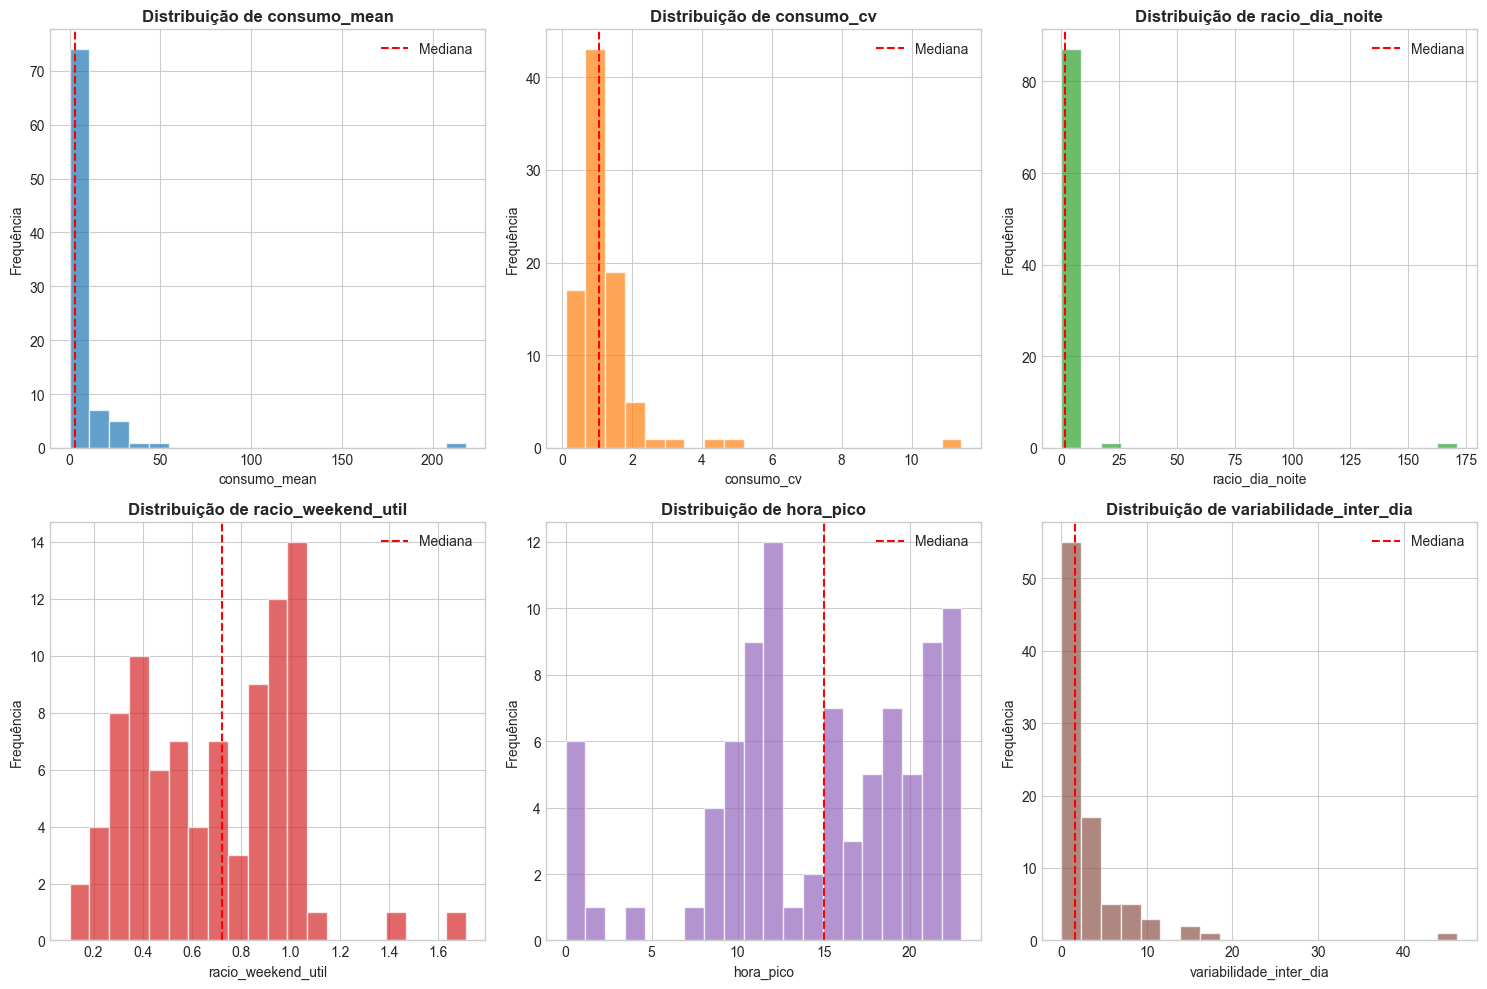

In [35]:
# Selecionar features principais para visualização
features_principais = ['consumo_mean', 'consumo_cv', 'racio_dia_noite', 'racio_weekend_util', 
                       'hora_pico', 'variabilidade_inter_dia']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feat in enumerate(features_principais):
    if feat in features_cpe.columns:
        ax = axes[i]
        ax.hist(features_cpe[feat].dropna(), bins=20, color=COLORS[i % len(COLORS)], edgecolor='white', alpha=0.7)
        ax.set_xlabel(feat)
        ax.set_ylabel('Frequência')
        ax.set_title(f'Distribuição de {feat}', fontweight='bold')
        ax.axvline(features_cpe[feat].median(), color='red', linestyle='--', label=f'Mediana')
        ax.legend()

plt.tight_layout()
plt.show()

### 4.2 Matriz de Correlação das Features

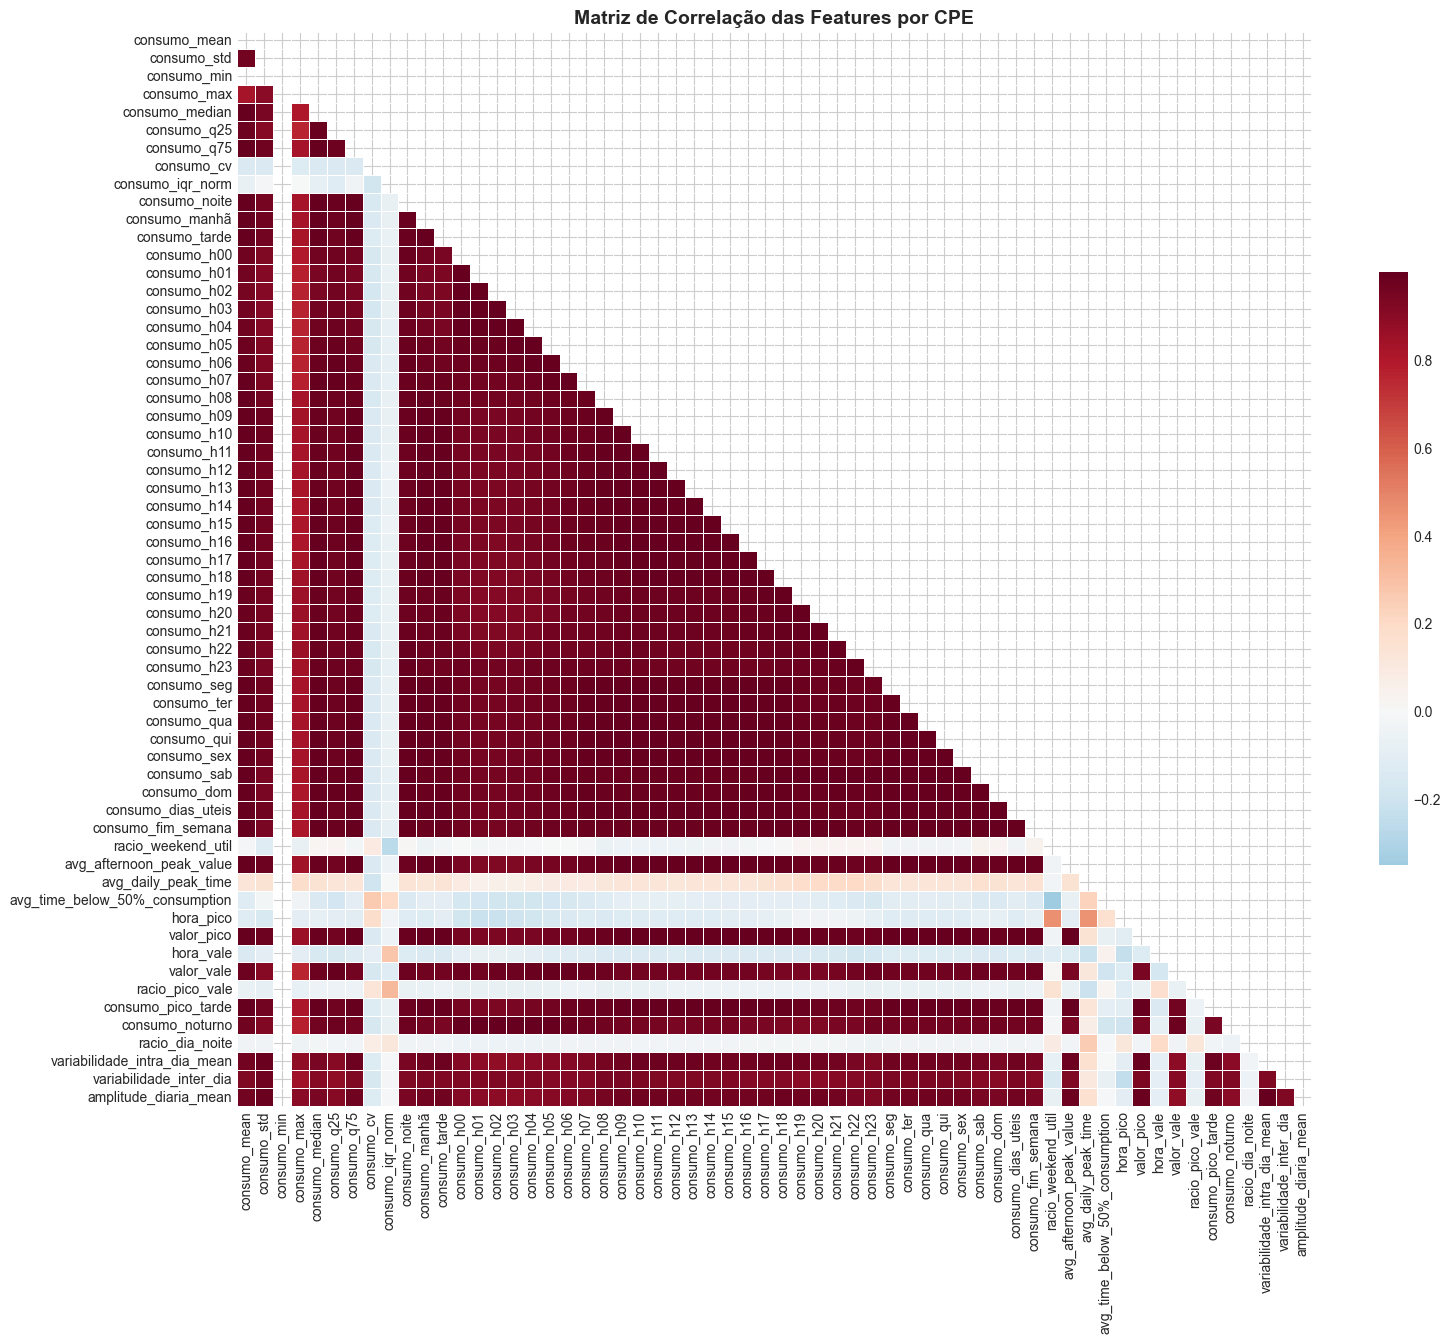

In [36]:
# Selecionar features numéricas para correlação
numeric_features = features_cpe.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != 'n_registos']  # Excluir n_registos

# Calcular matriz de correlação
corr_matrix = features_cpe[numeric_features].corr()

# Visualizar
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, ax=ax, 
            cbar_kws={'shrink': 0.5}, annot=False)
ax.set_title('Matriz de Correlação das Features por CPE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [37]:
# Identificar features altamente correlacionadas (potencial multicolinearidade)
threshold = CORR_THRESHOLD_HIGH
high_corr_pairs = []
medium_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = abs(corr_matrix.iloc[i, j])
        if corr_value > threshold:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlação': corr_matrix.iloc[i, j]
            })
        elif corr_value > CORR_THRESHOLD_MEDIUM:
            medium_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlação': corr_matrix.iloc[i, j]
            })

print(f"Análise de correlação (thresholds: alta>{CORR_THRESHOLD_HIGH}, média>{CORR_THRESHOLD_MEDIUM}):")
print(f"  - Pares com correlação alta: {len(high_corr_pairs)}")
print(f"  - Pares com correlação média: {len(medium_corr_pairs)}")

if high_corr_pairs:
    print(f"\n⚠️  Pares com correlação > {threshold} (considerar remoção para evitar multicolinearidade):")
    print(pd.DataFrame(high_corr_pairs).to_string(index=False))
else:
    print(f"\n✅ Não há pares com correlação > {threshold}. Boa diversidade de features!")

if medium_corr_pairs and VERBOSE:
    print(f"\n📊 Pares com correlação média ({CORR_THRESHOLD_MEDIUM}-{threshold}):")
    print(pd.DataFrame(medium_corr_pairs).head(10).to_string(index=False))
    if len(medium_corr_pairs) > 10:
        print(f"  ... e mais {len(medium_corr_pairs) - 10} pares")

Análise de correlação (thresholds: alta>0.9, média>0.7):
  - Pares com correlação alta: 1166
  - Pares com correlação média: 59

⚠️  Pares com correlação > 0.9 (considerar remoção para evitar multicolinearidade):
                   Feature 1                    Feature 2  Correlação
                consumo_mean                  consumo_std      0.9663
                consumo_mean               consumo_median      0.9954
                consumo_mean                  consumo_q25      0.9829
                consumo_mean                  consumo_q75      0.9979
                consumo_mean                consumo_noite      0.9944
                consumo_mean                consumo_manhã      0.9979
                consumo_mean                consumo_tarde      0.9972
                consumo_mean                  consumo_h00      0.9702
                consumo_mean                  consumo_h01      0.9578
                consumo_mean                  consumo_h02      0.9573
                c

### 4.3 Perfis de Consumo por Hora

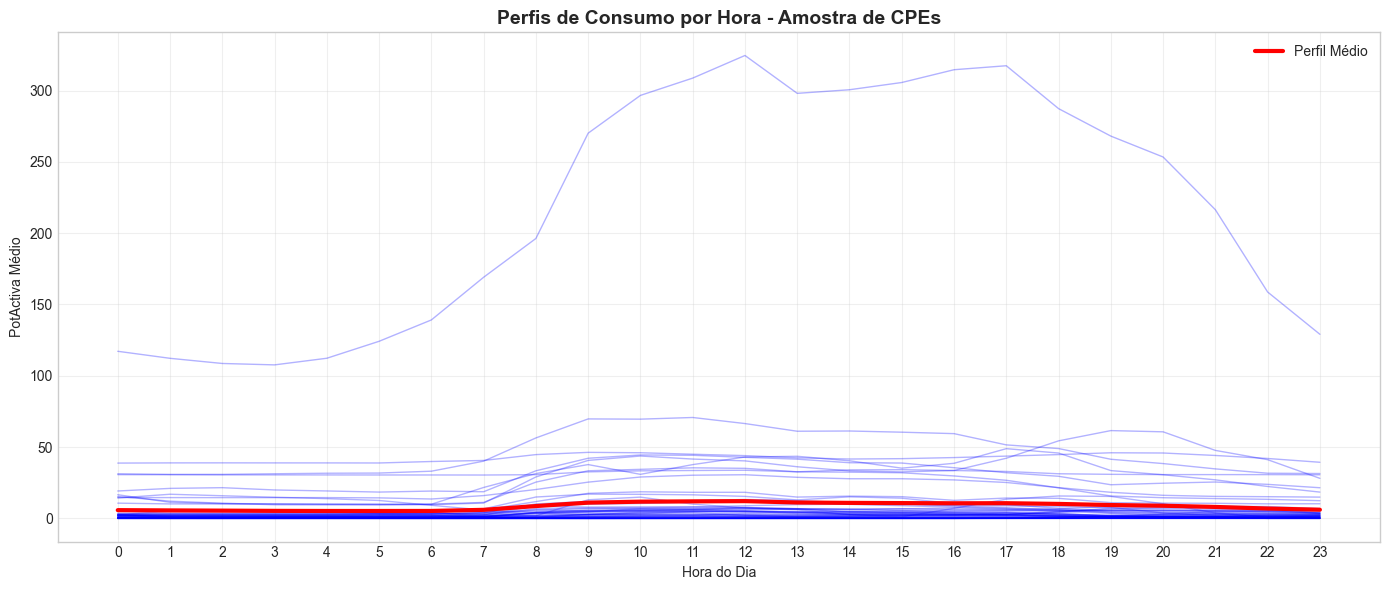

In [38]:
# Extrair colunas de consumo por hora
cols_hora = [col for col in features_cpe.columns if col.startswith('consumo_h')]

# Plotar perfis de consumo para todos os CPEs (amostra para evitar sobrecarga)
fig, ax = plt.subplots(figsize=(14, 6))

# Plotar apenas uma amostra de CPEs para visualização clara
sample_cpes = features_cpe.sample(min(50, len(features_cpe)), random_state=42)
for idx, row in sample_cpes.iterrows():
    valores = [row[col] for col in cols_hora]
    ax.plot(range(24), valores, alpha=0.3, linewidth=1, color='blue')

# Adicionar perfil médio de todos os CPEs
perfil_medio = features_cpe[cols_hora].mean().values
ax.plot(range(24), perfil_medio, color='red', linewidth=3, label='Perfil Médio')

ax.set_xlabel('Hora do Dia')
ax.set_ylabel(f'{TARGET_COL} Médio')
ax.set_title('Perfis de Consumo por Hora - Amostra de CPEs', fontsize=14, fontweight='bold')
ax.set_xticks(range(24))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 5. Próximos Passos

Com os dados preparados e features criadas, o projeto avança para as fases de modelação:

1. **03_clustering_analysis.ipynb**:
   - Aplicação de algoritmos de clustering (K-Means, DBSCAN)
   - Identificação de perfis de consumo
   - Interpretação dos clusters encontrados

2. **04_time_series_forecasting.ipynb**:
   - Modelos ARIMA e LSTM para previsão de séries temporais
   - Comparação com baseline "semana anterior"
   - Avaliação de performance temporal

3. **05_feature_based_prediction.ipynb**:
   - Random Forest, XGBoost e MLP usando features agregadas
   - Análise do impacto da normalização
   - Comparação com abordagens de séries temporais

---

## 6. Resumo e Conclusões

In [39]:
print("=" * 80)
print("RESUMO - DATA PREPARATION & FEATURE ENGINEERING")
print("=" * 80)

print(f"\n📊 DADOS ORIGINAIS:")
print(f"   • Total de registos: {len(df):,}")
print(f"   • Total de CPEs: {df['CPE'].nunique()}")

print(f"\n🔍 FILTRAGEM DE CPEs:")
print(f"   • Critérios: ≥{MIN_SEMANAS} semanas, ≥{MIN_COMPLETUDE}% completude")
print(f"   • CPEs válidos: {len(cpes_validos)}")
print(f"   • CPEs excluídos: {len(cpes_excluidos)}")

print(f"\n📁 FICHEIROS GERADOS:")
print(f"   • data/intermediate/d4maia_series_per_cpe.csv")
print(f"   • data/intermediate/d4maia_ts_train_test_index.csv")
print(f"   • data/intermediate/d4maia_cpe_features.csv")

print(f"\n🎯 FEATURES CRIADAS:")
print(f"   • Total: {features_cpe.shape[1] - 1} features por CPE")
print(f"   • Categorias:")
print(f"     - Estatísticas gerais de consumo")
print(f"     - Consumo por período do dia")
print(f"     - Consumo por hora (24 valores)")
print(f"     - Consumo por dia da semana")
print(f"     - Rácios fim de semana/dias úteis")
print(f"     - Features de pico e vale")
print(f"     - Features de variabilidade")

print(f"\n✅ SPLIT TREINO/TESTE:")
print(f"   • Rácio: {TRAIN_RATIO*100:.0f}% treino / {(1-TRAIN_RATIO)*100:.0f}% teste")
print(f"   • Split definido individualmente por CPE (corte temporal)")

print(f"\n💡 PRÓXIMOS PASSOS:")
print(f"   1. Clustering (K-Means, DBSCAN) - notebook 03")
print(f"   2. Séries temporais (ARIMA, LSTM) - notebook 04")
print(f"   3. Modelos supervisionados (RF, XGB, MLP) - notebook 05")

RESUMO - DATA PREPARATION & FEATURE ENGINEERING

📊 DADOS ORIGINAIS:
   • Total de registos: 5,940,182
   • Total de CPEs: 91

🔍 FILTRAGEM DE CPEs:
   • Critérios: ≥8 semanas, ≥70% completude
   • CPEs válidos: 89
   • CPEs excluídos: 2

📁 FICHEIROS GERADOS:
   • data/intermediate/d4maia_series_per_cpe.csv
   • data/intermediate/d4maia_ts_train_test_index.csv
   • data/intermediate/d4maia_cpe_features.csv

🎯 FEATURES CRIADAS:
   • Total: 61 features por CPE
   • Categorias:
     - Estatísticas gerais de consumo
     - Consumo por período do dia
     - Consumo por hora (24 valores)
     - Consumo por dia da semana
     - Rácios fim de semana/dias úteis
     - Features de pico e vale
     - Features de variabilidade

✅ SPLIT TREINO/TESTE:
   • Rácio: 70% treino / 30% teste
   • Split definido individualmente por CPE (corte temporal)

💡 PRÓXIMOS PASSOS:
   1. Clustering (K-Means, DBSCAN) - notebook 03
   2. Séries temporais (ARIMA, LSTM) - notebook 04
   3. Modelos supervisionados (RF, XGB

In [40]:
print("\n" + "=" * 80)
print("Notebook de Data Preparation & Feature Engineering concluído!")
print("=" * 80)


Notebook de Data Preparation & Feature Engineering concluído!
